# Integration of BCR and GEX data

## Introduction

10x BCR (B cell receptor) data and 10x GEX (gene expression) data can borrow information from each other for an improved analysis. This tutorial demonstrates a few approaches to integrating these data types along with examples on how the new information can be used. The example datasets (**BCR.data.rds** and **GEX.data.rds**) can be downloaded in a zip file from [here](https://yale.box.com/shared/static/6s8gzxxpfb3vmwx2izn9qur9teultzvu.zip).

In [6]:
# make sure the environment is clear
rm(list = ls())

# show some useful information
cat(R.Version()$version.string, 
    paste("Platform:", R.Version()$platform), 
    paste("Running under:", sessionInfo()$running),
    sep = "\n")
cat("\n")

# load the required packages
packages <- c("dplyr", "ggplot2", "Seurat")
for (n in 1:length(packages)) {
    suppressPackageStartupMessages(library(packages[n], character.only = TRUE))
    cat(paste0(packages[n], ": ", packageVersion(packages[n]), "\n"))
}

# set the data directory
path_data <- file.path("..", "immcantation-BCR-Seurat-tutorial") # change this to fit your own directory structure

R version 3.6.0 (2019-04-26)
Platform: x86_64-w64-mingw32
Running under: Windows 10 x64 (build 19042)

dplyr: 1.0.4
ggplot2: 3.3.3
Seurat: 3.2.2


In this tutorial, we will integrate the BCR and GEX data by using the cell barcodes. However, since cell barcodes can be duplicated in multiple samples, we suggest concatenating the sample ids with the cell ids in order to ensure the uniqueness of cell barcodes across multiple samples. The sample ids can be added as a prefix to the existing cell ids when the GEX data is being processed with a Seurat command such as `gex_obj <- RenameCells(object = gex_obj, add.cell.id = sample)`. 

*Note: We have already added the sample ids to the cell ids as such in the example GEX data.*

In [23]:
# read in the data
gex_obj <- readRDS(file.path(path_data, "GEX.data.rds"))
bcr_data <- readRDS(file.path(path_data, "BCR.data.rds"))

# concatenate the sample id (sample) and cell id (cell_id) in the BCR data
bcr_data <- bcr_data %>% rowwise() %>%
            mutate(cell_id_unique = paste(sample, strsplit(cell_id, split = "-")[[1]][1], sep = "_"))

## Integration of BCR data with the GEX Seurat object

The meta.data data slot in the Seurat object contains metadata for each cell and is a good place to hold information from BCR data.
* For example, we can indicate if a cell in the GEX data has a corresponding BCR or not by adding a column called “contains_bcr”.
* If the column “has_BCR” is true, then we can add other useful BCR data information such as clonal lineage, mutation frequency, isotype, etc. to the metadata slot.
* The new columns in Seurat object use names defined by the [AIRR standard](https://docs.airr-community.org/en/stable/index.html), but prefixed with "bcr_".*

### Create the new metadata columns

In [15]:
new_meta_cols <- data.frame(cell_id_unique = Cells(gex_obj))

# select columns from BCR data
bcr_data_selected <- bcr_data %>% select(cell_id_unique, clone_id, mu_freq, isotype) %>%
                     rename(bcr_clone_id = clone_id, 
                            bcr_mu_freq = mu_freq, 
                            bcr_isotype = isotype)

# sort BCR data by cell id in GEX Seurat Object
new_meta_cols <- left_join(new_meta_cols, bcr_data_selected, by = 'cell_id_unique') 

# integrate BCR data with the Seurat object 
for (colname in colnames(bcr_data_selected)) {
   gex_obj[[colname]] = new_meta_cols[[colname]]
}
gex_obj$contains_bcr <- !is.na(gex_obj$bcr_clone_id)

# examples of the new columns
ncol_meta <- ncol(gex_obj[[]])
gex_obj[[]][, (ncol_meta-3):ncol_meta] %>% slice_sample(n = 5) # row names = cell ids

,bcr_clone_id,bcr_mu_freq,bcr_isotype,contains_bcr
,<int>,<dbl>,<chr>,<lgl>
P05_FNA_0_Y1_GGGTTGCGTCATACTG,1064,0.03508772,IgM,TRUE
P05_FNA_90_Y1_CCGGTAGTCTGTCCGT,NA,NA,NA,FALSE
P05_FNA_3_12_Y1_TTTGCGCTCGGTGTTA,28316,0.04861111,IgG,TRUE
P05_FNA_3_28_Y1_CGGAGTCTCTCTAGGA,76885,0.07291667,IgG,TRUE
P05_FNA_3_12_Y1_CACACTCCAGCCACCA,111846,0.01374570,IgM,TRUE


### Highlight BCR cells in the GEX UMAP

After we integrate the BCR data into the Seurat object, we can highlight BCR cells in a GEX UMAP plot to check if annotations based upon biomarker gene expression are accurate or not.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



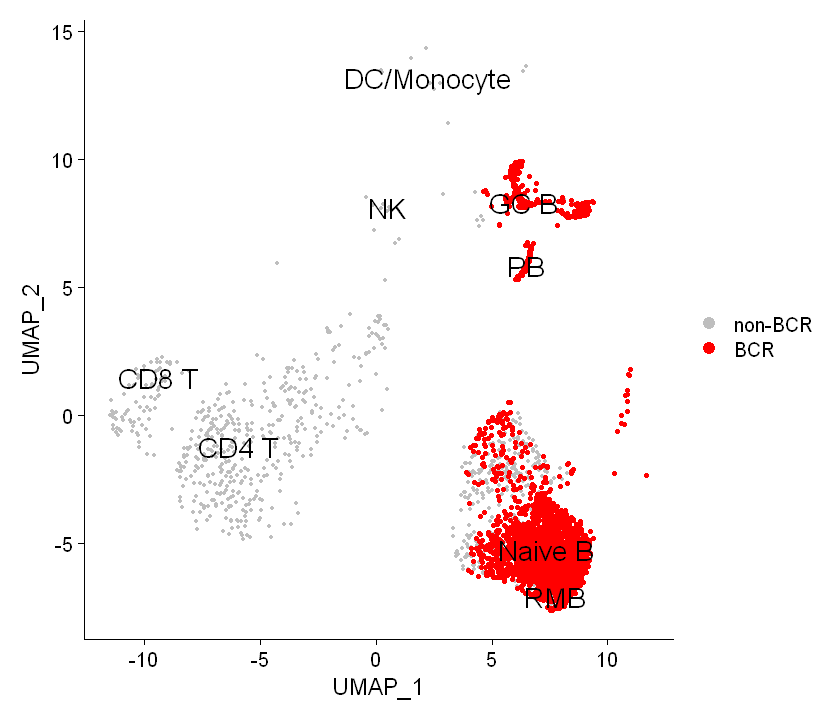

In [17]:
highlighted_cells <- Cells(gex_obj)[which(gex_obj$contains_bcr)]

options(repr.plot.width = 7, repr.plot.height = 6)
UMAPPlot(object = gex_obj, cells.highlight = highlighted_cells, 
         label = TRUE, label.size = 6, pt.size = 0.7) +
scale_color_manual(labels = c("non-BCR", "BCR"), values = c("gray", "red"))

As we can see, there is a very good correlation between the BCR cells (in red) and the clusters labeled as B cells.

*UMAP labels note: DC = dendritic cells, GC B = germinal center B cells, NK = natural killer cells, PB = plasmablasts, RMB = resting memory B cells*

## Integration of GEX cell annotations in the BCR data 

The annotatation information of B cells (such as sub-types of B cells and their associated UMAP coordinates) identified by the GEX data can be integrated into BCR data.

### Add GEX information to the BCR data

In [29]:
# select columns from the GEX data
gex_data_selected <- data.frame(cell_id_unique = Cells(gex_obj),
                                gex_umap_1 = gex_obj@reductions$umap@cell.embeddings[,1],
                                gex_umap_2 = gex_obj@reductions$umap@cell.embeddings[,2],
                                gex_annotation = as.character(Idents(gex_obj)))

# integrate GEX data with the BCR data
bcr_gex_data <- left_join(bcr_data, gex_data_selected, by = 'cell_id_unique') 

# keep BCR cells has matched cells from GEX data
bcr_gex_data <- filter(bcr_gex_data, !is.na(gex_annotation))

# examples of the new columns
ncol_bcr_gex <- ncol(bcr_gex_data)
head(bcr_gex_data[, (ncol_bcr_gex-3):ncol_bcr_gex])

cell_id_unique,gex_umap_1,gex_umap_2,gex_annotation
<chr>,<dbl>,<dbl>,<fct>
P05_FNA_60_Y1_GGCCGATTCAACACGT,7.041733,-3.690460,Naive B
P05_FNA_12_Y1_ACGGGTCCACAAGCCC,5.969869,-4.751089,Naive B
P05_FNA_2_60_Y1_CTGCTGTAGACACGAC,5.977537,9.178997,GC B
P05_FNA_2_5_Y1_ATAAGAGAGAAACGCC,8.186502,-4.663070,Naive B
P05_FNA_60_Y1_TGATTTCCAGTGGGAT,7.518584,-6.491421,Naive B
P05_FNA_12_Y1_TTGTAGGTCGCAAACT,6.324341,8.344568,GC B


### Identify GEX clusters in the BCR UMAP

Using the annotated information, we can layout cells from the BCR data in a UMAP plot color-coded by the B cell subtypes.

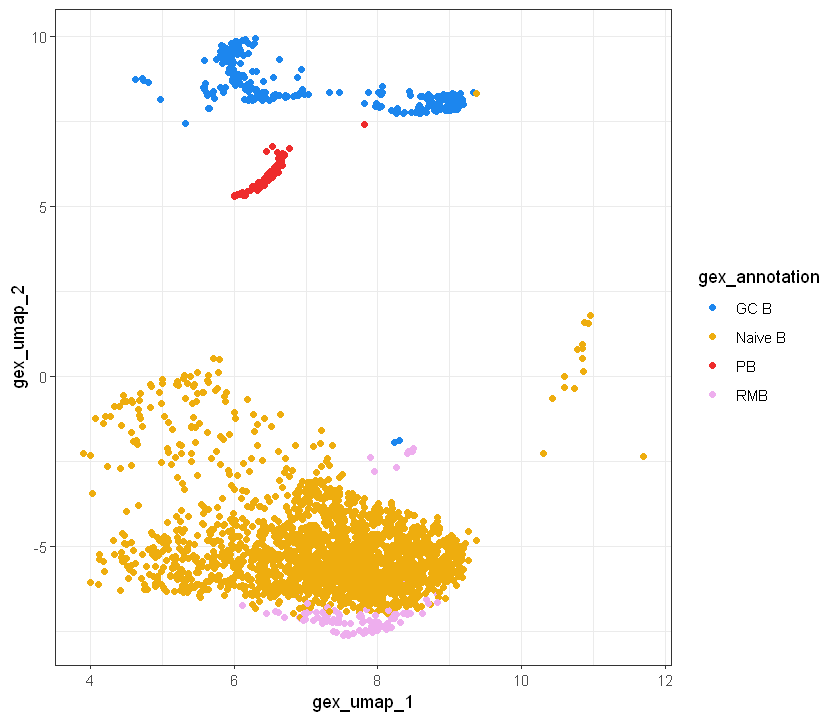

In [37]:
anno_cols <- c("GC B" = "dodgerblue2", "Naive B" = "darkgoldenrod2", "PB" = "firebrick2", "RMB" = "plum2")

options(repr.plot.width = 7, repr.plot.height = 6)
ggplot() + geom_point(data = bcr_gex_data, aes(x = gex_umap_1, y = gex_umap_2, color = gex_annotation)) +
           scale_colour_manual(values = anno_cols) + theme_bw()

### Other BCR features in UMAPs

Characteristics associated with the BCR can also be displayed in UMAP plots. The plots below show the mutation frequencies and isotypes of GC B cells at various time points.

In [32]:
options(repr.plot.width = 16, repr.plot.height = 4)

# base plot
p <- ggplot() + geom_point(data = filter(bcr_gex_data, gex_annotation != "GC B"), 
                           aes(x = gex_umap_1, y = gex_umap_2), color = "lightgray", size = 1) + 
                theme_bw() + facet_wrap(~day, nrow = 1)

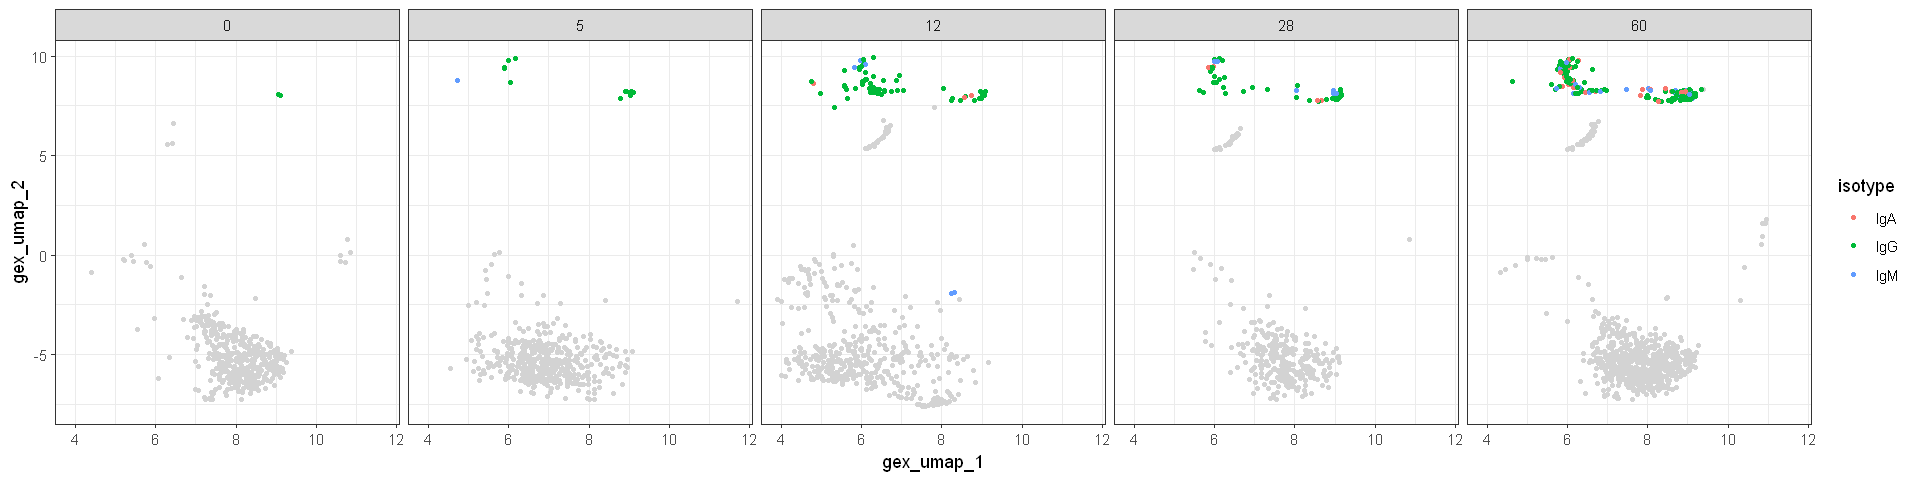

In [33]:
# isotype information
p + geom_point(data = filter(bcr_gex_data, gex_annotation == "GC B"), 
               aes(x = gex_umap_1, y = gex_umap_2, color = isotype), size = 1)

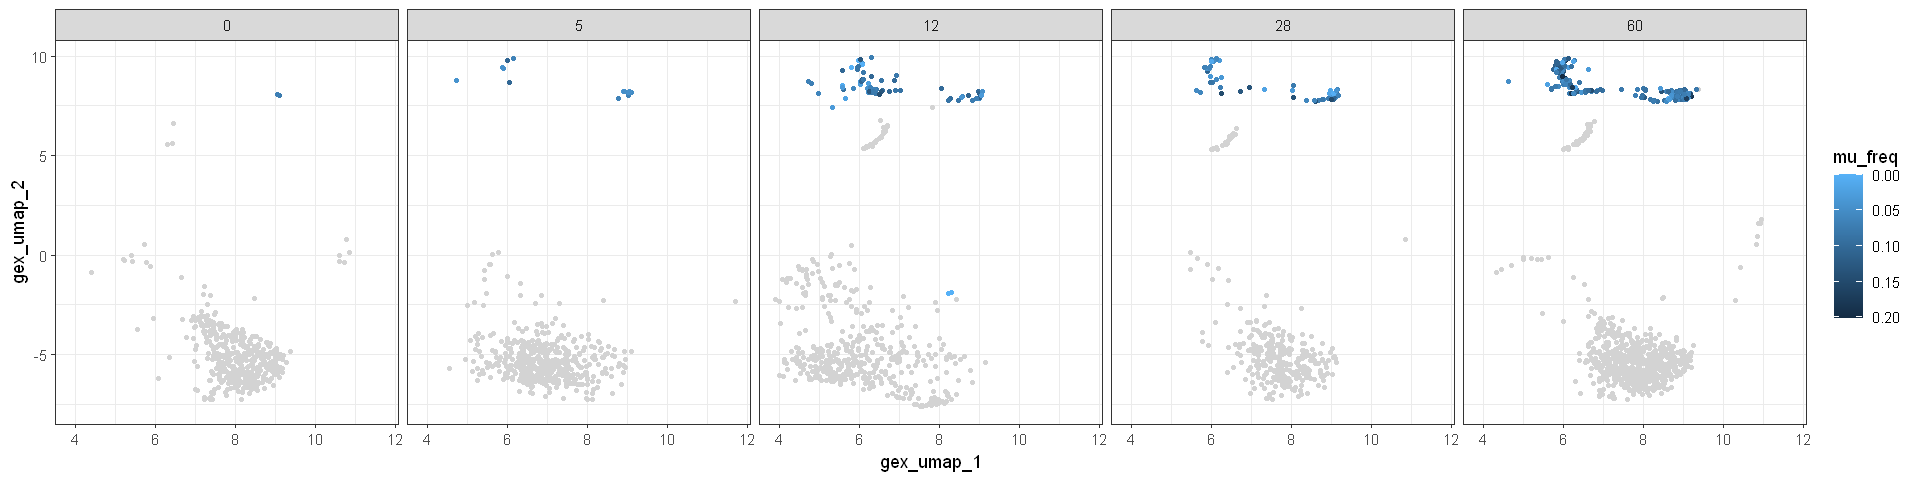

In [34]:
# mutation frequency
p + geom_point(data = filter(bcr_gex_data, gex_annotation == "GC B"), 
               aes(x = gex_umap_1, y = gex_umap_2, color = mu_freq), size = 1) +
    scale_colour_continuous(trans = 'reverse') 